Goal: To demonstrate the neural net architecture for code2seq

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.datasets import AmazonReviewFull

import numpy as np
import matplotlib.pylab as plt

import pickle
import os
import operator

Get some C++/python source code

Generate ASTs

Generate AST paths

node_to_index, index_to_node: IfStmt -> 0, 0 -> IfStmt

merge_sort -> AST -> 15 paths -> file: [1, 5, 2, 3, ...], [10, 54, ...], merge_sort

-----------------------------------------

model.py: python model.py train DATA_LOC -> persisted stuff, validation score (30%)

### Dataset

In [2]:
dp_train = AmazonReviewFull(root='../', split='train')
dp_test = AmazonReviewFull(root='../', split='test')

In [3]:
batch_size = 64
dl_train = DataLoader(dp_train, batch_size=batch_size)
dl_test = DataLoader(dp_test, batch_size=batch_size)

In [12]:
y, X = next(iter(dl_train)) #sample one batch of data

In [15]:
print(X[7]) #review
print(y[7]) #rating

Errors, but great story I was a dissapointed to see errors on the back cover, but since I paid for the book I read it anyway. I have to say I love it. I couldn't put it down. I read the whole book in two hours. I say buy it. I say read it. It is sad, but it gives an interesting point of view on church today. We spend too much time looking at the faults of others. I also enjoyed beloved.Sincerly,Jaylynn R
tensor(4)


### Vocabulary

In [24]:
#test processing of single sentence
np.unique(np.concatenate([s.strip().replace(',','').split() for s in X[7].lower().split('.')]), return_counts=True)

(array(['a', 'also', 'an', 'anyway', 'at', 'back', 'beloved', 'book',
        'but', 'buy', 'church', "couldn't", 'cover', 'dissapointed',
        'down', 'enjoyed', 'errors', 'faults', 'for', 'gives', 'great',
        'have', 'hours', 'i', 'in', 'interesting', 'is', 'it', 'looking',
        'love', 'much', 'of', 'on', 'others', 'paid', 'point', 'put', 'r',
        'read', 'sad', 'say', 'see', 'since', 'sincerlyjaylynn', 'spend',
        'story', 'the', 'time', 'to', 'today', 'too', 'two', 'view', 'was',
        'we', 'whole'], dtype='<U15'),
 array([ 1,  1,  1,  1,  1,  1,  1,  2,  3,  1,  1,  1,  1,  1,  1,  1,  2,
         1,  1,  1,  1,  1,  1, 10,  1,  1,  1,  7,  1,  1,  1,  2,  2,  1,
         1,  1,  1,  1,  3,  1,  3,  1,  1,  1,  1,  1,  4,  1,  2,  1,  1,
         1,  1,  1,  1,  1]))

In [25]:
#build dictionary of word counts i.e. word -> occurrence count

def get_counts(dl_train):
    counts_dict = {}
    for y, X_batch in dl_train: #loop over batch
        #get unique words and counts from each sentence
        for X in X_batch: #loop over sentences in batch
            words, counts = np.unique(np.concatenate([s.strip().replace(',','').split() for s in X.lower().split('.')]), return_counts=True)

            for idx, w in enumerate(words):
                if w not in counts_dict:
                    counts_dict[w] = 0

                counts_dict[w] += counts[idx]
    return counts_dict

/home/sanjay/Downloads/venv_pytorch/lib64/python3.9/site-packages/torch/utils/data/datapipes/iter/combining.py:248: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [38]:
if not os.path.exists('train_word_counts.pkl'):
    print('Computing word counts...')
    counts_dict = get_counts(dl_train)
    pickle.dump(counts_dict, open('train_word_counts.pkl','wb'))
else:
    print('Reading pre-computed word counts...')
    counts_dict = pickle.load(open('train_word_counts.pkl','rb'))

Reading pre-computed word counts...


In [42]:
#print entries with decreasing word counts
counts_sorted = sorted(counts_dict.items(), key=operator.itemgetter(1), reverse=True)

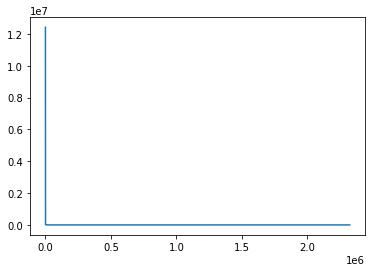

In [43]:
plt.plot([s[1] for s in counts_sorted])

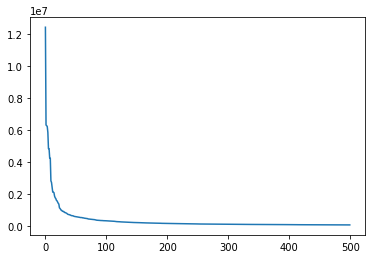

In [45]:
plt.plot([s[1] for s in counts_sorted[0:500]])

In [53]:
len(counts_sorted)

2323521

In [55]:
print('position from top, word, count')
for i in np.power(10, np.arange(6)):
    print(i, counts_sorted[i])

position from top, word, count
1 ('and', 6300311)
10 ('for', 2704868)
100 ('am', 307976)
1000 ('table', 22410)
10000 ('goodwill', 1025)
100000 ('waterfowl', 26)


Out of ~2.3 million words, even the 100,000th word has only a count of 26. Let's truncate our word list here (feel free to choose a smaller threshold for the exercise), and remove all less frequent words i.e. replace with ''.

In [77]:
valid_words = dict(counts_sorted[0:10000])

In [82]:
w2i = dict(zip(valid_words.keys(), np.arange(len(valid_words))))
i2w = dict(zip(np.arange(len(valid_words)), valid_words.keys()))

### Data format

From now on, we will work with just one batch of data or even just one data point i.e. one review. The idea is to put a model architecture together that we expect to be able to predict the ratings. In other words, we want an encoder that will encode a paragraph i.e. a sequence of sentences. There are multiple ways of doing this but we will focus on a model similar to code2seq.

In [57]:
y, X = next(iter(dl_train)) #sample one batch of data

In [88]:
idx = 7
review = []
for s in X[idx].lower().replace(',', '').split('.'): #loop over sentences
    sent = []
    for w in s.split(): #loop over words
        if w in valid_words:
            sent.append(w2i[w])
    review.append(sent)

In [89]:
review

[[1202,
  13,
  31,
  95,
  2,
  12,
  3,
  1491,
  4,
  126,
  1202,
  17,
  0,
  117,
  343,
  13,
  189,
  2,
  714,
  10,
  0,
  18,
  2,
  52,
  6,
  772],
 [2, 19, 4, 153, 2, 85, 6],
 [2, 357, 160, 6, 172],
 [2, 52, 0, 290, 18, 9, 118, 497],
 [2, 153, 92, 6],
 [2, 153, 52, 6],
 [6, 7, 738, 13, 6, 501, 38, 190, 340, 5, 710, 17, 1578, 639],
 [78, 682, 72, 65, 59, 176, 34, 0, 7135, 5, 314],
 [2, 89, 306, 4897],
 [1529]]

In the above example, we performed the following steps:

* Select a review

* Split into sentences

* For each word in the sentence, (a) check if the word is a valid (frequently occuring) word. if not, remove the word, (b) map the valid word to its index using w2i

Our goal is to motivate the architecture for code2seq. If we were just solving the review rating problem, one could treat the whole review as a sequence of tokens since there is a time order imposed on the sentences. For AST paths though, there is no such order. So we have to treat each AST path on an equivalent footing. This motivates the idea of using one encoder to encode each sentence separately.

#### Padding and packing

PyTorch operations benefit from SIMD for matrix operations. Sequences, on the other hand, are generally of varying lengths and not packed in matrices. PyTorch has a few functions to "pad" and "pack" sequences so they can be treated as matrices for efficient computation.

Padding is a simple idea. Extend every sequence to have a length equal to the longest sequence by inserting extra symbols.

In [99]:
#padding sequence - notice the extra -1 values in each column. Each column is one sentence
nn.utils.rnn.pad_sequence([torch.tensor(r) for r in review], padding_value=-1)

tensor([[1202,    2,    2,    2,    2,    2,    6,   78,    2, 1529],
        [  13,   19,  357,   52,  153,  153,    7,  682,   89,   -1],
        [  31,    4,  160,    0,   92,   52,  738,   72,  306,   -1],
        [  95,  153,    6,  290,    6,    6,   13,   65, 4897,   -1],
        [   2,    2,  172,   18,   -1,   -1,    6,   59,   -1,   -1],
        [  12,   85,   -1,    9,   -1,   -1,  501,  176,   -1,   -1],
        [   3,    6,   -1,  118,   -1,   -1,   38,   34,   -1,   -1],
        [1491,   -1,   -1,  497,   -1,   -1,  190,    0,   -1,   -1],
        [   4,   -1,   -1,   -1,   -1,   -1,  340, 7135,   -1,   -1],
        [ 126,   -1,   -1,   -1,   -1,   -1,    5,    5,   -1,   -1],
        [1202,   -1,   -1,   -1,   -1,   -1,  710,  314,   -1,   -1],
        [  17,   -1,   -1,   -1,   -1,   -1,   17,   -1,   -1,   -1],
        [   0,   -1,   -1,   -1,   -1,   -1, 1578,   -1,   -1,   -1],
        [ 117,   -1,   -1,   -1,   -1,   -1,  639,   -1,   -1,   -1],
        [ 343,   -1,

In [103]:
print(len(review))
nn.utils.rnn.pad_sequence([torch.tensor(r) for r in review], padding_value=-1).shape #(max sequence length, number of sequences)

10


torch.Size([26, 10])

In [106]:
nn.utils.rnn.pad_sequence([torch.tensor(r) for r in review], batch_first=True, padding_value=-1).shape #(number of sequences, max length of sequences)

torch.Size([10, 26])

Packing "flattens" all the data (see matrix above and ignore the -1 values) into a tensor but keeps track of each row in the batch_sizes variable. In the example below, "data" is a list of all values in the sequences in "review". "batch_sizes" indicates that the first 10 entries belong to row 1 (or time-step 1), the next 9 entries belong to row/time-step 2, etc.

PyTorch RNNs (and LSTMs, GRUs) accept packed sequences as inputs as we will see below.

In [107]:
#pack sequence
nn.utils.rnn.pack_sequence([torch.tensor(r) for r in review], enforce_sorted=False)

PackedSequence(data=tensor([1202,    6,   78,    2,    2,    2,    2,    2,    2, 1529,   13,    7,
         682,   52,   19,  357,  153,  153,   89,   31,  738,   72,    0,    4,
         160,   92,   52,  306,   95,   13,   65,  290,  153,    6,    6,    6,
        4897,    2,    6,   59,   18,    2,  172,   12,  501,  176,    9,   85,
           3,   38,   34,  118,    6, 1491,  190,    0,  497,    4,  340, 7135,
         126,    5,    5, 1202,  710,  314,   17,   17,    0, 1578,  117,  639,
         343,   13,  189,    2,  714,   10,    0,   18,    2,   52,    6,  772]), batch_sizes=tensor([10,  9,  9,  9,  6,  5,  5,  4,  3,  3,  3,  2,  2,  2,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1]), sorted_indices=tensor([0, 6, 7, 3, 1, 2, 4, 5, 8, 9]), unsorted_indices=tensor([0, 4, 5, 3, 6, 7, 1, 2, 8, 9]))

#### Embeddings

Another useful notion is that of an embedding. In the sequences above, each word is mapped to a unique integer. We could pass these integers as input to the neural network but they impose an ordering on the words which are fundamentally unordered. Another option would be to map each integer i to a vector, v of length N (N = total number of words in the vocabulary) where v[i] = 1 and v[j] = 0, $j\neq i$. This imposes the condition that two distinct words are orthogonal i.e. $v_i . v_j = \delta_{ij}$, which is not correct either.

Ideally, we would map each word to a vector $w \mapsto v_{w}$ where semantically similar words $w_1, w_2$ map to close-by vectors i.e. with $v_{w_1}.v_{w_2} \approx 1$ and dissimilar words $w_1, w_2$ map to orthgonal vectors i.e. $v_{w_1}.v_{w_2} \approx 0$.

The deep learning answer to this problem is embeddings, which are hash tables where each integer/word is mapped to a vector of fixed dimensionality. These vectors are initialized randomly but are treated as weights during the training process. In other words, backpropagation computes the derivative of the loss with respect to the embedding vectors and gradient descent (Adam etc.) is used to modify them. The result is that the embeddings are learned based on the task and often satisfy the property of similarity mentioned in the previous paragraph.

Using embeddings is easy.

In [169]:
emb = nn.Embedding(num_embeddings=10, embedding_dim=32)

emb(torch.tensor(0))

tensor([-1.1352, -0.0457, -1.4809, -0.7751,  0.3591,  0.3170, -0.9488,  1.5229,
         0.7727, -0.1353,  0.2212, -0.5189, -0.1412,  0.5595,  0.8167,  0.2851,
         0.6403, -0.9905, -1.1056,  1.7136,  0.5320, -1.2148, -1.0359,  0.7805,
        -0.7933,  0.5040,  0.0517,  0.1210, -1.1327, -0.9171,  0.8764, -0.4645],
       grad_fn=<EmbeddingBackward0>)

In [170]:
emb(torch.tensor(9))

tensor([ 0.5617, -2.6761, -1.1619, -1.2152, -0.2980,  0.8669, -0.1940,  1.8178,
        -1.3877, -2.5781, -0.0604,  1.6899, -0.4111,  1.3562,  0.8966,  0.9183,
        -1.0733, -1.1135, -0.4686, -0.4965, -0.0448,  0.9987, -1.1136, -1.2014,
         1.1637,  0.1104,  2.2933, -0.2891, -0.9864,  0.9162, -0.1472,  0.0468],
       grad_fn=<EmbeddingBackward0>)

In [171]:
emb(torch.tensor(10)) #doesn't exist since we specified num_embeddings = 10

IndexError: index out of range in self

The general flow is to do the following:

Step 1: Tokenize the sequences (sentences in the review) and map each token to a unique integer based on the w2i dictionary.

In [172]:
idx = 7
review = []
for s in X[idx].lower().replace(',', '').split('.'): #loop over sentences
    sent = []
    for w in s.split(): #loop over words
        if w in valid_words:
            sent.append(w2i[w])
    review.append(sent)

review

[[1202,
  13,
  31,
  95,
  2,
  12,
  3,
  1491,
  4,
  126,
  1202,
  17,
  0,
  117,
  343,
  13,
  189,
  2,
  714,
  10,
  0,
  18,
  2,
  52,
  6,
  772],
 [2, 19, 4, 153, 2, 85, 6],
 [2, 357, 160, 6, 172],
 [2, 52, 0, 290, 18, 9, 118, 497],
 [2, 153, 92, 6],
 [2, 153, 52, 6],
 [6, 7, 738, 13, 6, 501, 38, 190, 340, 5, 710, 17, 1578, 639],
 [78, 682, 72, 65, 59, 176, 34, 0, 7135, 5, 314],
 [2, 89, 306, 4897],
 [1529]]

In [174]:
#this is a list of lengths of each sequence that we'll need later
lens = [len(r) for r in review]
print(lens)

[26, 7, 5, 8, 4, 4, 14, 11, 4, 1]


Step 2: pad the sequence with a special symbol, say 0. Note that we should have been more careful above and set w2i['pad'] = 0 and i2w[0] = 'pad'. Let's pretend this is the case for now.

In [177]:
review_padded = nn.utils.rnn.pad_sequence([torch.tensor(r) for r in review], padding_value=0, batch_first=True)
review_padded.shape #note the shape is (number of sequences, length of longest sequence)

torch.Size([10, 26])

In [178]:
review_padded

tensor([[1202,   13,   31,   95,    2,   12,    3, 1491,    4,  126, 1202,   17,
            0,  117,  343,   13,  189,    2,  714,   10,    0,   18,    2,   52,
            6,  772],
        [   2,   19,    4,  153,    2,   85,    6,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,  357,  160,    6,  172,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,   52,    0,  290,   18,    9,  118,  497,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,  153,   92,    6,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,  153,   52,    6,    0,    0,    0,    0,    0,    0,    0,    0,

Step 3: Use an embedding table to map each integer to its embedding

In [179]:
emb = nn.Embedding(num_embeddings=len(w2i), embedding_dim=32)

In [180]:
emb(review_padded).shape #(num sequences/batch size, max length, embedding_dim)

torch.Size([10, 26, 32])

Step 4: pack this sequence. the packed sequence can be used as an input to an RNN/LSTM/GRU

In [181]:
review_padded_packed = nn.utils.rnn.pack_padded_sequence(emb(review_padded), lens, batch_first=True, enforce_sorted=False)
review_padded_packed

PackedSequence(data=tensor([[ 0.9094,  0.1121,  0.9202,  ..., -0.3945,  0.2835, -0.2500],
        [ 0.5067, -0.0297, -0.1504,  ...,  1.2191,  0.0949,  0.9311],
        [-0.4212,  0.1985,  0.2637,  ..., -1.1615, -0.5108,  0.9925],
        ...,
        [-0.5124, -0.5845, -0.8453,  ...,  1.4230,  0.3747, -0.2386],
        [ 0.5067, -0.0297, -0.1504,  ...,  1.2191,  0.0949,  0.9311],
        [ 0.8317,  0.0165, -1.0567,  ..., -0.4114,  0.1026,  0.3873]],
       grad_fn=<PackPaddedSequenceBackward0>), batch_sizes=tensor([10,  9,  9,  9,  6,  5,  5,  4,  3,  3,  3,  2,  2,  2,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1]), sorted_indices=tensor([0, 6, 7, 3, 1, 2, 4, 5, 8, 9]), unsorted_indices=tensor([0, 4, 5, 3, 6, 7, 1, 2, 8, 9]))

In [182]:
review_padded_packed.data.shape #there's one embedded vector for each non-zero entry in the reviews_padded tensor

torch.Size([84, 32])

In [183]:
np.sum(lens)

84

Step 5: Pass packed sequence as an input to the LSTM. The output, hidden and cell states are all packed sequences

In [184]:
o, (h,c) = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)(review_padded_packed)
print(type(o))
print(type(h))
print(type(c))

<class 'torch.nn.utils.rnn.PackedSequence'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Step 6: Unpack the sequences

In [185]:
o, l_o = nn.utils.rnn.pad_packed_sequence(o, batch_first=True)

In [186]:
print(o.shape)
print(h.shape)
print(c.shape)

torch.Size([10, 26, 64])
torch.Size([1, 10, 64])
torch.Size([1, 10, 64])


Step 7: For code2seq, we will work with the hidden states at the last time-step, $h$. It is sometimes useful to insert a small MLP (just one layer in this case) as a projector.

In [187]:
proj = nn.Linear(64, 32)
h_proj = proj(h)

In [188]:
h_proj.shape

torch.Size([1, 10, 32])

This is the end of the encoding part. Step 8 would be a decoder that's application specific. In the sentence classification or function name prediction problem, the decoder would simply use h_proj to predict a distribution over n labels. E.g.,

In [189]:
out_nn = nn.Sequential(nn.Linear(32, 64), nn.ReLU(), nn.Linear(64, 5)) #5 is number of unique labels

In [194]:
pred = out_nn(h_proj.squeeze(1).sum(dim=1))

Special note: Since there is no ordering on the sequence hidden activation vectors, h_proj, any network should ideally be permutation invariant. A general way of doing so is to add all the vectors together (see DeepSets paper to see that this is all one needs)

The loss would be cross-entropy loss (essentially log likelihood)

In [195]:
criterion = nn.CrossEntropyLoss()

In [197]:
criterion(pred, y[7].unsqueeze(0))

tensor(1.7229, grad_fn=<NllLossBackward0>)

### Model prototyping

In [115]:
class Code2Seq(nn.Module):
    def __init__(self,
                 vocab_size,
                 emb_dim,
                ):
        
        #1
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)
        
        #2
        self.encoder = nn.LSTM(input_size=emb_dim,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               batch_first=True,
                               bidirectional=False,
                              )
        
        #3
        self.lin_proj = nn.Linear(hidden_size, hidden_size)
        
        #4
        
    def forward(self, x):
        '''This can be optimizer but stick to simple version for now
        '''
        
        #x is a list of sequences of integers
        e = self.emb(x)